<a href="https://colab.research.google.com/github/Engenery/Segway/blob/main/Eyes_detection_to_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 1: 

For this tutorial, you will have to work on a different object detection task. Your task will be to detect if a person is wearing a mask or not. Don't worry about the images, you will have to use the [Mask Wearing Dataset](https://public.roboflow.com/object-detection/mask-wearing). In the end, you will have to test your model with a different sample downloaded from Google Images with the script provided in the midterm exam. 


## 1. Download the model 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clone the model 
!git clone https://github.com/ultralytics/yolov5  

# install dependencies
!pip install -U -r yolov5/requirements.txt  

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
# access the yolov5 folder and show the model's architecture
%cd /content/yolov5
%cat /content/yolov5/models/yolov5s.yaml

/content/yolov5
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4],

In [ ]:
import torch
from IPython.display import Image  # for displaying images
#from utils.google_utils import gdrive_download  # for downloading models/datasets

# check if we're using torch with GPU
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [ ]:
# You need to sign up in roboflow to get the key and then you can use the dataset
!curl -L "https://app.roboflow.com/ds/ZukFAyZYIk?key=jALhU57TvS" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
# !ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0    586      0  0:00:01  0:00:01 --:--:--   586
100 26.9M  100 26.9M    0     0  9366k      0  0:00:02  0:00:02 --:--:-- 42.4M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/20211209_113555-0-_jpg.rf.b31197c300922f7ce6dbb908fb20420b.jpg  
 extracting: test/images/20211209_113558_jpg.rf.28f9a3c425f33d207fb9d20c0e417eda.jpg  
 extracting: test/images/20211209_113601-0-_jpg.rf.1edbbc3b88657fbd202996cded0034a0.jpg  
 extracting: test/images/20211209_113601_jpg.rf.66d9cd7de336c71588f6a11526d94022.jpg  
 extracting: test/images/20211209_113605-0-_jpg.rf.d29955ab52ad6097416c7a6e9a5b14be.jpg  
 extracting: test/images/20211209_113608_jpg.rf.c1becacf5c

In [ ]:
# visualise the content of data.yaml
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['c_eyes', 'o_eyes']

In [ ]:
# define the number of classes
num_classes = 2

# IPython is a great tool for interactive shells as Notebooks. It comes with 
# many utilities and we will use register_line_cell_magic
# to overwrite a file directly from a Colab cell. Otherwise, we would need to 
# download and upload the file. We define writetemplate to customize iPython 
# writefile 
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
# change the location of the training and validation subsets. The rest
# of the file remains equal. 

%%writetemplate /content/yolov5/data.yaml

train: ./train/images
val: ./test/images

nc: 2
names: ['c_eyes', 'o_eyes']

In [ ]:
%cat data.yaml


train: ./train/images
val: ./test/images

nc: 2
names: ['c_eyes', 'o_eyes']

In [ ]:
# change the number of classes defined in the yolo v5 architectures. the rest remains the same. 
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes 
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat models/custom_yolov5s.yaml


# parameters
nc: 2  # number of classes 
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[

###Train the model

In [ ]:
# Since we exported the dataset for Yolo v5, we don't need to resize the images.
# We will train the model for 5 epoch with batch size of 80, however, you can 
# change these parameters to get a better performance
# train.py uses the subsets information from data.yaml. 

%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data './data.yaml' --cfg './models/yolov5s.yaml' --weights '' --name yolov5s_results --cache
#!python train.py --img 416 --batch 16 --epochs 10 --data './data.yaml' --cfg './models/custom_yolov5s.yaml' --weights './runs/train/exp/weights'

/content/yolov5
train: weights=, cfg=./models/yolov5s.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-141-ge8ef8fb torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degr

## 4. Evaluate the model


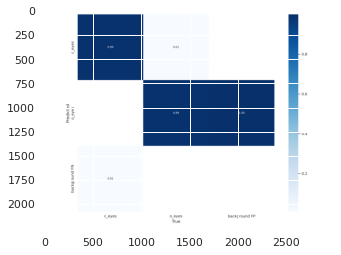

In [ ]:
# Launch after you have started training to all the graphs needed for inspection
# logs are saved in the folder "runs"
from yolov5.utils.metrics import *
import cv2

confusion_matrix = ConfusionMatrix(nc=2)

confusion_matrix.plot()

img = cv2.imread("/content/yolov5/runs/train/yolov5s_results4/confusion_matrix.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
# final weights will be stored by default at /content/yolov5/runs/train/exp2/weights/best.pt
%cd /content/yolov5/

!python detect.py --weights /content/yolov5/runs/train/yolov5s_results4/weights/best.pt --img 416 --conf 0.30 --source /content/yolov5/test/images
#!python detect.py --weights /content/drive/MyDrive/datasets/OID/ --img 416 --conf 0.4 --source /content/drive/MyDrive/datasets/OID/Dataset/test

/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results4/weights/best.pt'], source=/content/yolov5/test/images, imgsz=[416, 416], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-141-ge8ef8fb torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/210 /content/yolov5/test/images/20211209_113555-0-_jpg.rf.b31197c300922f7ce6dbb908fb20420b.jpg: 416x416 1 o_eyes, Done. (0.028s)
image 2/210 /content/yolov5/test/images/20211209_113558_jpg.rf.28f9a3c425f33d207fb9d20c0e417eda.jpg: 416x416 1 o_eyes, Done. (0.029s)
image 3/210 /content/yolov5/test/images/20211209_113601-0-_jpg.rf.1edbbc3b

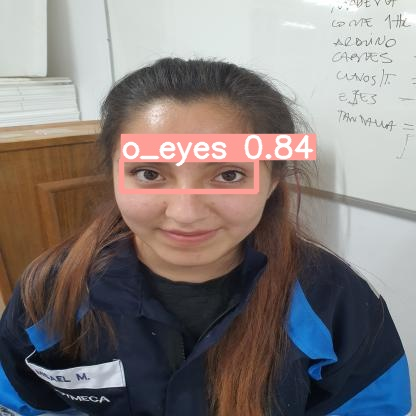

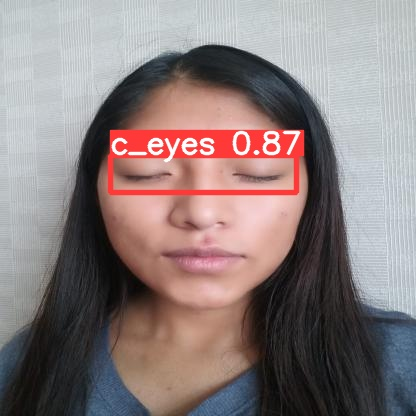

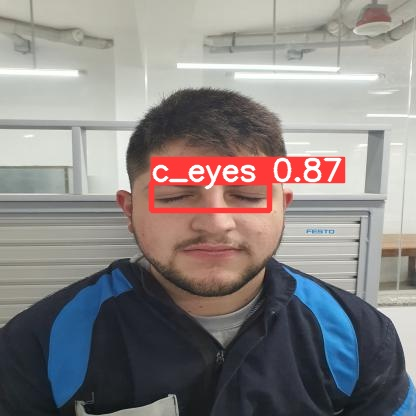

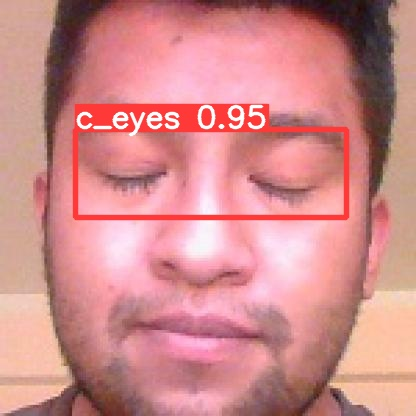

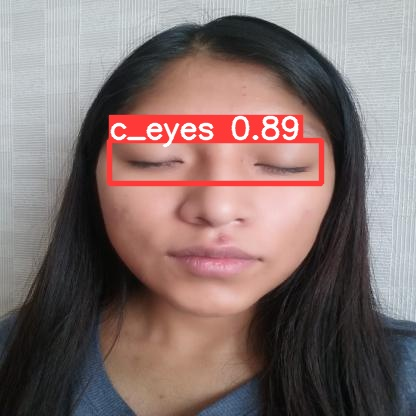

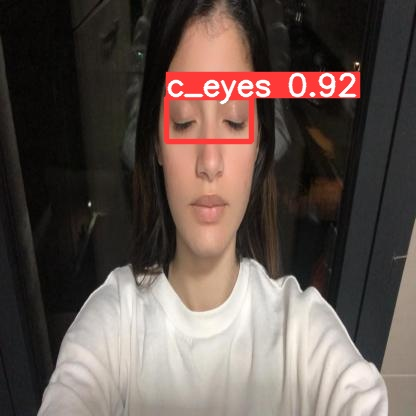

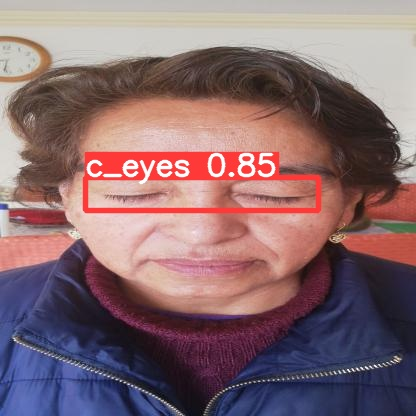

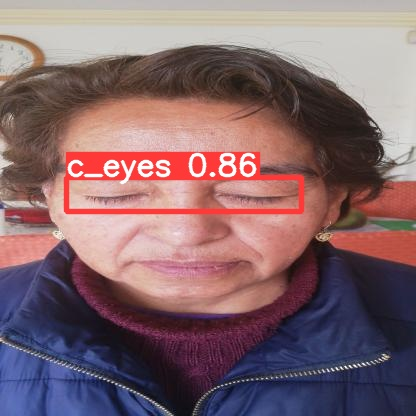

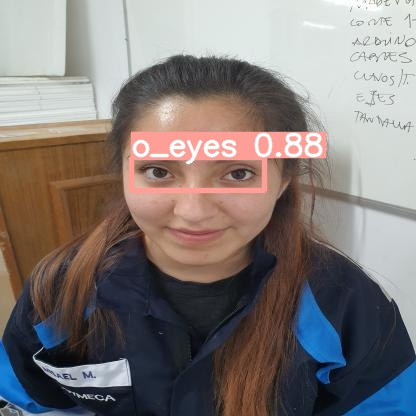

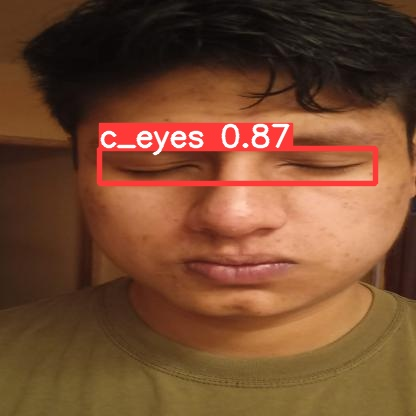

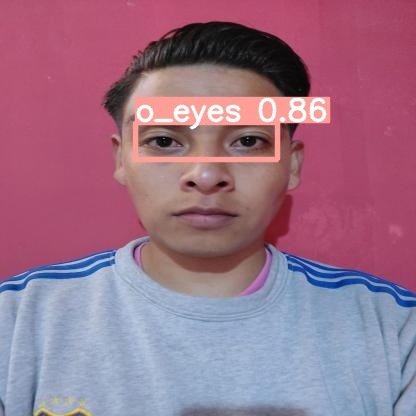

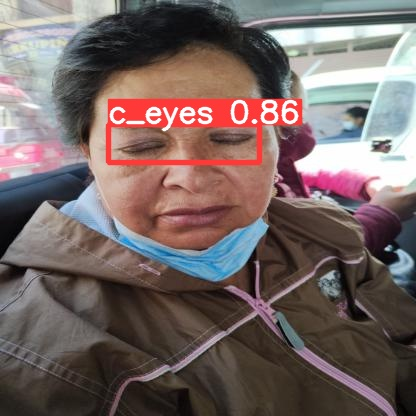

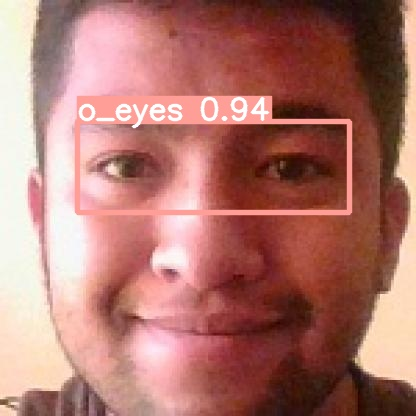

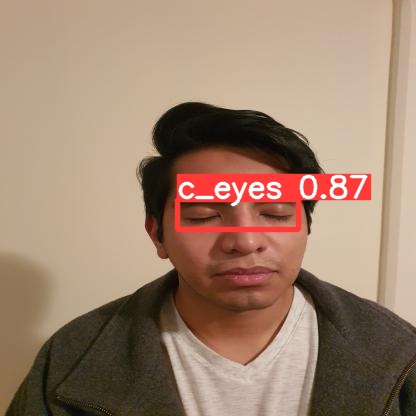

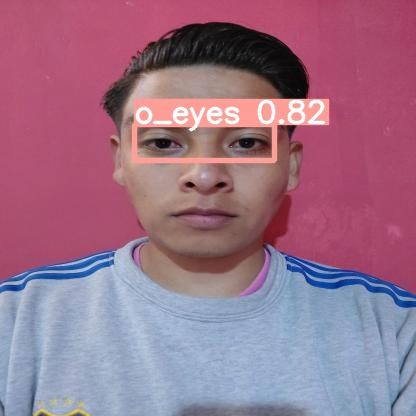

In [ ]:
import glob
from IPython.display import Image, display

for image in glob.glob('/content/yolov5/runs/detect/exp5/*.jpg')[:15]:
    display(Image(filename=image))
    print("\n")

###Save the model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cp /content/yolov5/runs/train/exp/weights/best.pt /content/gdrive/My\ Drive

Mounted at /content/gdrive
